# Global Model Interpretability: **shap**

### Explainers
- **Explainer**: Uses Shapley values to explain any machine learning model or python function.
- **LinearExplainer**: Computes SHAP values for a linear model, optionally accounting for inter-feature correlations.
- **TreeExplainer**: Uses Tree SHAP algorithms to explain the output of ensemble tree models.
- **KernelExplainer**: Uses the Kernel SHAP method to explain the output of any function.
- **AdditiveExplainer**: Computes SHAP values for generalized additive models (GAM).
- **GPUTreeExplainer**: Experimental GPU accelerated version of TreeExplainer. Currently requires source build with cuda available and 'CUDA_PATH' environment variable defined.
- **GradientExplainer**: Explains a model using expected gradients (an extension of integrated gradients - Sundararajan et al. 2017).
- **PartitionExplainer**: Uses Shapley values to explain any machine learning model or python function.
- **PermutationExplainer**: This method approximates the Shapley values by iterating through permutations of the inputs.
- **SamplingExplainer**: This is an extension of the Shapley sampling values explanation method (aka. IME). 

### References
- [SHAP: How to Interpret Machine Learning Models With Python](https://betterdatascience.com/shap/)
- [Introduction to SHAP with Python](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)

In [17]:
%%capture
pip install shap

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
from sklearn.datasets import fetch_california_housing, load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
import shap
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 35)

## load datasets

In [19]:
# boston dataset (regression)
boston = load_boston()
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df["Price"] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [20]:
# cancer (classification)
breast_cancer = load_breast_cancer()
breast_cancer_df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["TumorType"] = breast_cancer.target
breast_cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,TumorType
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Classification

In [21]:
# train - test split
print("Dataset Size : ", breast_cancer.data.shape, breast_cancer.target.shape)
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    train_size=0.90,
                                                    stratify=breast_cancer.target,
                                                    random_state=123)
print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Dataset Size :  (569, 30) (569,)
Train/Test Sizes :  (512, 30) (57, 30) (512,) (57,)


In [22]:
# model
model = RandomForestClassifier(max_depth=2, random_state=0)
# training model
model.fit(X_train, Y_train)
# scoring
test_preds = [0 if pred< 0.5 else 1 for pred in model.predict(X_test).flatten()]
train_preds = [0 if pred< 0.5 else 1 for pred in model.predict(X_train).flatten()]
print("Train Accuracy : %.2f"%accuracy_score(Y_train, train_preds))
print("Test  Accuracy : %.2f"%accuracy_score(Y_test, test_preds))
print("\nTest  Classification Report : ")
print(classification_report(Y_test, test_preds))

Train Accuracy : 0.97
Test  Accuracy : 0.91

Test  Classification Report : 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.92      0.94      0.93        36

    accuracy                           0.91        57
   macro avg       0.91      0.90      0.90        57
weighted avg       0.91      0.91      0.91        57



In [23]:
# initialize explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pd.DataFrame(X))

### Explaining single prediction

Let’s start small and simple. With SHAP, we can generate explanations for a single prediction. The SHAP plot shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value.

In [24]:
X = pd.DataFrame(X, columns = breast_cancer.feature_names)
# get a random sample
idx = random.randint(1, len(X))
print("Actual Class : %d"%y[idx])
sample = pd.DataFrame(X.iloc[idx:idx+1], columns = list(breast_cancer.feature_names))
sample

Actual Class : 1


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
508,16.3,15.7,104.7,819.8,0.09427,0.06712,0.05526,0.04563,0.1711,0.05657,0.2067,0.4706,1.146,20.67,0.007394,0.01203,0.0247,0.01431,0.01344,0.002569,17.32,17.76,109.8,928.2,0.1354,0.1361,0.1947,0.1357,0.23,0.0723


In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx], sample)

### Explaining single feature

To understand the effect a single feature has on the model output, we can plot a SHAP value of that feature vs. the value of the feature for all instances in the dataset.

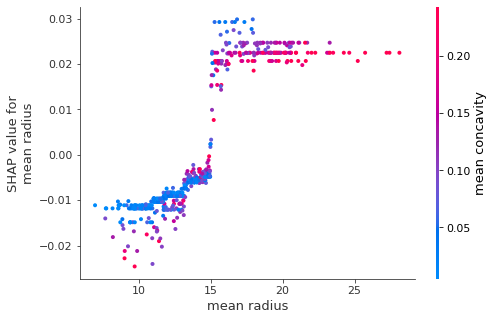

In [26]:
shap.dependence_plot('mean radius', shap_values[0], X)

### Explaining the entire dataset

We can visualize the importance of the features and their impact on the prediction by plotting summary charts. The one below sorts features by the sum of SHAP value magnitudes over all samples. It also uses SHAP values to show the distribution of the impacts each feature has.

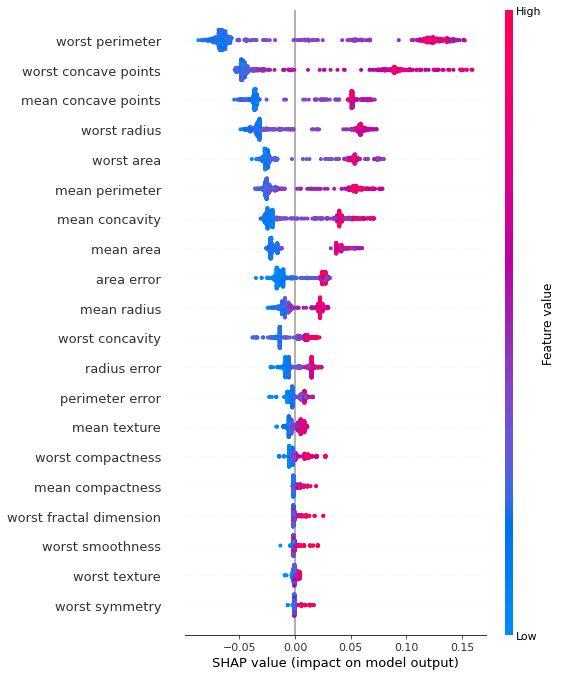

In [27]:
shap.summary_plot(shap_values[0], X)

## Regression

In [28]:
# train-test split
print("Dataset Size : ", boston.data.shape, boston.target.shape)
X = boston.data
y = boston.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    train_size=0.90,
                                                    random_state=123)
print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Dataset Size :  (506, 13) (506,)
Train/Test Sizes :  (455, 13) (51, 13) (455,) (51,)


In [29]:
# model
model = RandomForestRegressor(max_depth=2, random_state=0)
# training model
model.fit(X_train, Y_train)
# scores
print("Train MSE : %.2f"%mean_squared_error(Y_train, model.predict(X_train)))
print("Test  MSE : %.2f"%mean_squared_error(Y_test, model.predict(X_test)))
print("Train R2 Score : %.2f"%r2_score(Y_train, model.predict(X_train)))
print("Test  R2 Score : %.2f"%r2_score(Y_test, model.predict(X_test)))

Train MSE : 17.73
Test  MSE : 60.44
Train R2 Score : 0.78
Test  R2 Score : 0.47


In [38]:
X = pd.DataFrame(boston.data, columns = boston.feature_names)
# initialize explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
explainer_0 = shap.Explainer(model, X)
shap_values_0 = explainer_0(X)


### Waterfall
To better understand this, let’s dive into our first SHAP plot. Below we have the code to create a waterfall plot for the first abalone in our dataset. You can see the output in Figure 3. This plot helps us visualise the SHAP values for each of the features. These tell us how much each of the features have increased or decreased the predicted number of rings for this specific abalone.

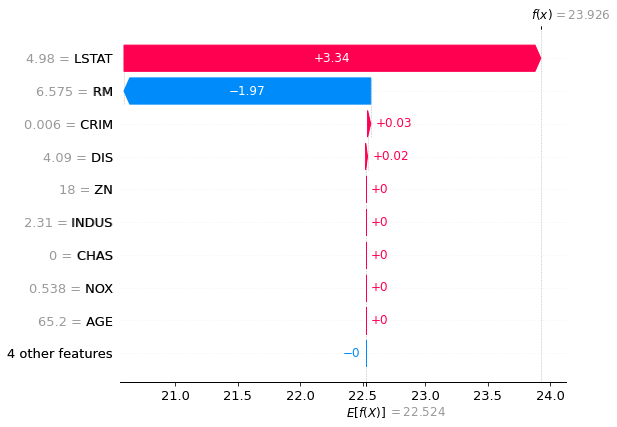

In [40]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_0[0])

### Explaining single prediction

Let’s start small and simple. With SHAP, we can generate explanations for a single prediction. The SHAP plot shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value.

In [34]:
# get a random sample
idx = random.randint(1, len(X))
idx = 0
print("Actual Class : %f"%y[idx])
sample = pd.DataFrame(X.iloc[idx:idx+1], columns = list(boston.feature_names))
sample

Actual Class : 24.000000


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


In [37]:
shap.force_plot(explainer.expected_value, shap_values[0], features = sample, feature_names = sample.columns.tolist())

In [42]:
shap.force_plot(shap_values_0)

### Decision Plot
Waterfall and force plots are great for interpreting individual predictions. To understand how our model makes predictions in general we need to aggregate the SHAP values. One way to do this is using a decision plot. Below we have the code used to output the decision plot for the first 10 abalones.

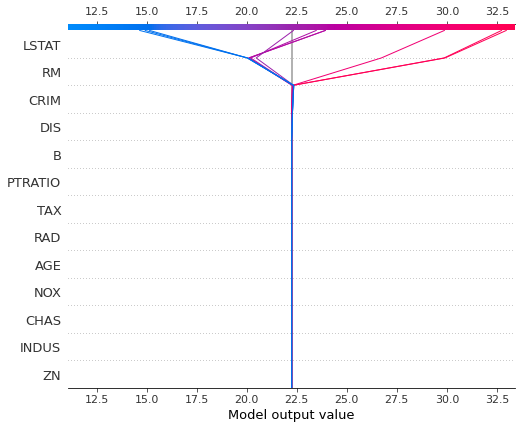

In [43]:

# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns))

### Mean SHAP
Another way to aggregate the values is using a mean SHAP plot. For each feature, we calculate the mean of the absolute SHAP values across all observations. We take the absolute values as we do not want positive and negative values to offset each other. There is one bar for each feature and we can see that shell weight had the largest mean SHAP out of all the features.

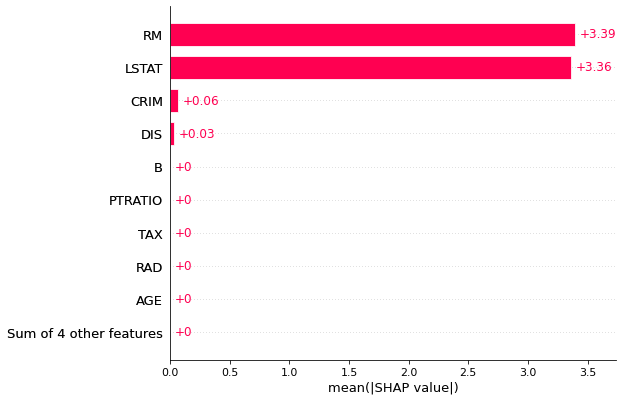

In [45]:
#Mean SHAP
shap.plots.bar(shap_values_0)

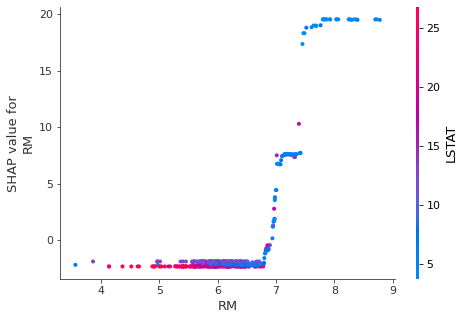

In [47]:
shap.dependence_plot(ind = 'RM', shap_values = shap_values, features = X, feature_names=X.columns.tolist())


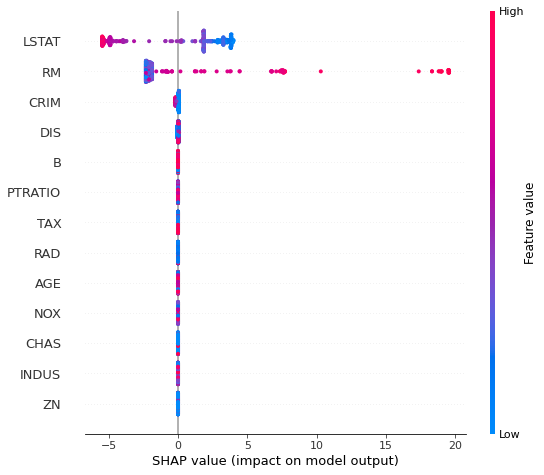

In [48]:
shap.summary_plot(shap_values, X)